# <strong>Cyfrowe Przetwarzanie Sygnałów</strong>


**Laboratorium nr 13 Przetwarzanie obrazów**

prof. dr hab. inż. Tomasz Zieliński, dr inż. Jarosław Bułat, mgr
inż. Artur Kos

Python/colab: Szymański Bartosz


---



# <strong>1. Cyfrowe znaki wodne (2+0.5 pkt)</strong>

Cyfrowe znaki wodne (nazywane dalej znakiami wodnymi) w obrazach mają na celu identyfikację obrazu, np. w celu potwierdzenia jego praw własności, co wiąże się np. z ochroną praw autorskich. Znak wodny to informacja (ciąg bitów) ukryta w obrazie. Znak wodny nie może być widoczny, powinien być nieusuwalny i niemożliwy do modyfikacji. Znak wodny musi też przetrwać operacje takie jak kopiowanie, usuwanie metadanych, skalowanie, obrót, kompresję stratną, kadrowanie, drukowanie i skanowanie, etc...

Przykładowy algorytm znakowania i dekodowania pokazano na poniższym schemacie.

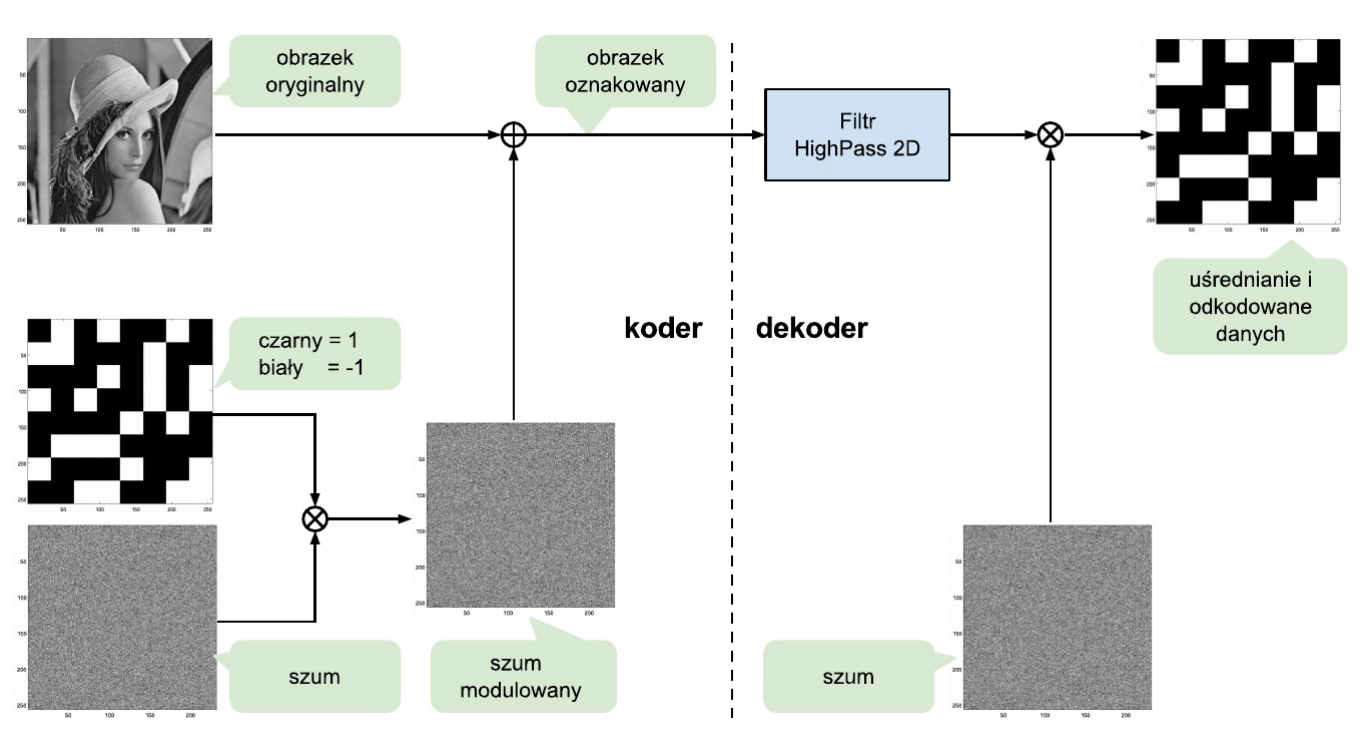

Znaki wodne mają postać dużych kwadratów (np. bloków o rozmiarze 32x32 pikseli), przyjmujących wartości -1 i 1. Następnie kwadraty te są mnożone z sygnałem losowym (szumem) i szum zmodulowany „kwadratami” jest dodawany do oryginalnego obrazka. W dekoderze sygnał jest filtrowany filtrem górnoprzepustowym i mnożony przez sygnał szumowy, identyczny jak w koderze, a potem uśredniany w granicach obszarów pojedynczych bloków danych.

Kilka ważnych obserwacji:

1.   Sygnał szumowy jest ,,tajny'', jego przechwycenie kompromituje algorytm ochrony danych.
2.   Zmodulowany szum ma amplitudę na poziomie 1% amplitudy właściwego sygnału (jasności pikseli obrazka), dlatego jest percepcyjnie niedostrzegalny.
3.   Szum ma rozkład Gaussa, dlatego przemnożenie go lokalnie przez -1 (białe piksele) nie zmienia jego statystycznych parametrów (średnia, wariancja). Z tego powodu nie jest możliwe odkrycie ,,w ciemno'' wartości bloków danych czy nawet ich położenia i rozmiaru.
4.   W dekoderze, mnożenie sygnału z tym samym sygnałem (szum przed modulacją!) powoduje jego wzmocnienie, przy czym czarne bloki mają wartość: szum*szum, a białe: szum*(-szum). Detekcja polega na uśrednieniu wartości w obrębie jednego bloku i obliczenie w nim znaku. Algorytm jest poprawny, jeżeli średnia wartość sygnału jest równa 0, o co dba filtr górno-przepustowy w dekoderze.

Dane ,,ukryte'' w opisanym algorytmie powinny przetrwać operacje skalowania i stratnej kompresji. Spróbujmy więc sprawdzić odporność algorytmu na te zniekształcenia. W pliku `watermark.m`  ([TZ2005], Tab. 22-10) zamieszczono algorytm, implementujący znakowanie i dekodowanie według powyższego algorytmu. 

Zapoznaj się z programem, zmniejsz rozmiar bloków w znaku wodnym, kodujących pojedynczy bit, sprawdź poprawność algorytmu na innym obrazku (np. `goldhill.png` albo `barbara.png`).

In [ ]:
import cv2
import gdown

gdown.download('https://drive.google.com/uc?id=1v39EBCmoAz7AdwAe0T023pLqiLmyHbDF', 'lena512.png', quiet=True)
A = cv2.imread('lena512.png', cv2.IMREAD_GRAYSCALE)  # Wczytaj obraz do znakowania
[M, N] = A.shape



---

Wyznacz (na obrazku `lena.png`) procent poprawnie zachowanej informacji +1/-1 znaku wodnego w funkcji zmiany rozdzielczości (skalowania) obrazu. Skaluj płynnie w granicach od 100% do 10% wykorzystując interpolację biliniową (najpierw zmniejsz obraz za pomocą funkcji `imresize(...)` a następnie przywróć oryginalny rozmiar za pomocą tej samej funkcji).

In [ ]:
import cv2
import gdown

gdown.download('https://drive.google.com/uc?id=1v39EBCmoAz7AdwAe0T023pLqiLmyHbDF', 'lena512.png', quiet=True)
A = cv2.imread('lena512.png', cv2.IMREAD_GRAYSCALE)  # Wczytaj obraz do znakowania
[M, N] = A.shape




---
<strong>Opcjonalnie</strong> (+0.25 pkt): Wyznacz (na obrazku `lena.png`) procent poprawnie zachowanej informacji znaku wodnego w funkcji jakości kompresji stratnej JPEG. Wykorzystaj implementację algorytmu JPEG z Matlaba.



---

<strong>Opcjonalnie</strong> (+0.25 pkt): Wykonaj znakowanie w dziedzinie współczynników DCT. Algorytm powinien być odporny na rotację obrazu (sprawdź!).

# <strong>2. Estymacja wektorów ruchu (2+0.5 pkt)</strong>

Estymacja wektorów ruchu jest narzędziem szeroko stosowanym w przetwarzaniu obrazów. Pozwala ono wyznaczyć przesunięcie tego samego obiektu na obrazach, zarejestrowanych w różnych chwilach czasowych lub z różnych ujęć (przesunięta kamera lub kilka kamer).

Algorytm jest wykorzystywany, między innymi, podczas kompresji sekwencji wideo, rekonstrukcji 3D z obrazu stereoskopowego, wyznaczania przesunięć/odkształceń obiektów w ruchu, etc... . Przykład takiej estymacji zaprezentowano na poniższym obrazku. Przedstawia on dwa zdjęcia zrobione w jednej chwili czasu, ale z różnych miejsc. Rysunek przedstawia fragment ujęć `L188Undistorted.png` i `P188Undistorted.png`. Białe linie oznaczają referencyjny układ współrzędnych, czerwonymi strzałkami zaznaczono obliczone wektory ruchu pomiędzy lewym i prawym obrazem. Wykorzystano algorytm ,,dopasowania bloków'' (ang. block matching), którego implementacja znajduje się w funkcji `motionEstES(...)`. Jest ona zmodyfikowaną wersją algorytmu ze strony http://teledsp.kt.agh.edu.pl/18/index.html. 

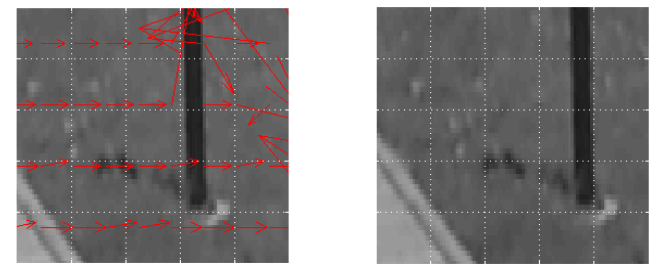

Zauważmy, że nie wszystkie wektory zostasły poprawnie obliczone, co jest typowym błedem tej metody.

Metoda ,,dopasowania bloków'' polega na wycięciu fragmentu (bloku pikseli) obrazu i poszukiwaniu podobnego fragmentu w drugim obrazie w ,,okolicy'' pierwszego bloku. Zazwyczaj przeszukiwany jest obszar w ograniczonym promieniu (w tym przypadku 64 piksele). Przeszukiwane są wszystkie możliwe przesunięcia w osi X i Y w obrębie zadanego promienia. Porównywany obszar jest zazwyczaj kwadratem (w tym przypadku kwadratem o boku 12x12 pikseli). Wykorzystywana miara podobieństwa to MAE (ang. Mean Absolute Error) lub MAD (ang. Mean Absolute Difference), implementowany następująco:

$$
MAD=\frac{1}{MN}=\sum_{m=0}^{m=M-1} \sum_{n=0}^{n=N-1} |u_1(m,n)-u_2(m+mv_x,n+mv_y)|,
$$

gdzie: $M$ i $N$ to rozmiary bloku, $u_1(m,n)$ i $u_2(m,n)$ to punkt o współrzędnych $(m, n)$ odpowiednio na obrazie $u_1$ i $u_2$. Poszukiwany jest taki wektor przesunięcia $(mv_x, mv_y)$ dla którego wartość MAD jest najmniejsza.

Algorytm analizy wygląda następująco:

*   z lewego obrazu wycięto blok pikseli o rozmiarze 12x12 (bloki wycięto w regularnej siatce co 12 pikseli w kierunku osi X i Y, początki strzałek wskazują środki tych bloków),
*   na prawym obrazie poszukiwano podobnych (w sensie MAD) bloków pikseli w odległości +-64 pikseli w kierunku X i Y od początkowego położenia,
*  grot strzałki oznacza przesunięcie, dla którego wartość MAD była najmniejsza spośród wszystkich przeszukanych.

Napisz program wykorzystujący funkcję `motionEstES(...)` do wyznaczania wektorów ruchu. Funkcja zwraca macierz, w której każda kolumna to jeden wektor w formacie [x; y; mvx; mvy]. Narysuj wektory na obrazku za pomocą funkcji `quiver(...)`. (Funkcja `quiver(...)` skaluje długości wektorów. Standardowo wyświetla pole wektorów tak żeby było czytelne ale niekoniecznie o poprawnej długości wektorów). Jako obrazków wejściowych użyj  `L188Undistorted.png` i `P188Undistorted.png`. Dodatkowo wykonaj dwa zdjęcia (komórką, aparatem, kalkulatorem) jakiegoś obiektu, oblicz i narysuj wektory ruchu. Zdjęcia możesz wykonać:

*   podczas ruchu postępowego kamery (ang. egomotion),
*   podczas obrotu kamery względem osi optycznej obiektywu,
*   podczas równoległego przesunięcia kamery do obiektu (ang. panning),
*   nieruchomą kamerą, z poruszającym się obiektem w kadrze (np. poruszający się samochód).

Zadbaj aby zdjęcia były wyraźne, bez rozmycia spowodowanego gwałtownym ruchem. Obiekty widoczne w kadrze muszą posiadać wyraźną teksturę – fotografowanie białej ściany nie jest dobrym pomysłem. Sprawdź czy wektory ruchu odpowiadają zaobserwowanemu przesunięciu.

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import gdown

gdown.download('https://drive.google.com/uc?id=1yqNif50hbgtVO-dZhUFXm3Kq5HGTzWi3', 'L188Undistorted.png', quiet=True)
gdown.download('https://drive.google.com/uc?id=1vRdCvfGmlK0JKBiuEKB0JIMsv4dUvLev', 'P188Undistorted.png', quiet=True)




---


<strong>Opcjonalnie</strong> (+0.25 pkt): zmodyfikuj algorytm tak, aby usuwał błędnie wyznaczone wektory, tj. takie,  dla których najmniejsza wartość MAD jest nadal duża (wyznacz próg parametru MAD).



---


<strong>Opcjonalnie</strong> (+0.25 pkt): przyspiesz algorytm. W tym celu, wyznacz wektory w siatce rzadszej niż zazwyczaj, np. co piąty wektor w kierunku X i Y (25 raz mniej obliczeń!). Następnie oblicz brakujące wektory metodą interpolacji wyznaczonych wektorów (użyj interpolacji biliniowej). Interpolowane wektory potraktuj jako punkt startowy do wyznaczania właściwego wektora ruchu. Załóż, że interpolowany wektor jest ,,blisko'' wektora właściwego, dlatego przeszukiwanie możesz wykonać w mniejszym obszarze.

# <strong> 3. Stabilizacja obrazu (1+0.5 pkt) </strong>

Podczas filmowania telefonem komórkowym, szczególnie uciążliwym zjawiskiem są drgania obrazu spowodowane brakiem lub niewystarczającą stabilizacją optyczną kamery. Zjawisko to można ograniczyć za pomocą tzw. programowej stabilizacji. Można do tego celu wykorzystać wektory ruchu wyznaczone w pkt. 2.

Film `unstable_video.avi` pokazuje jedną statyczną scenę. Poruszenia obrazu są niewielkie ale uciążliwe. W związku z tym, że kamera skierowana jest cały czas na jedno miejsce, można założyć, że występuje tylko przesunięcie obrazu w płaszczyźnie X-Y.

Z zarejestrowanego filmu zapisano do plików `000000XX.png` pierwszych 10 ramek video. Potraktuj pierwszy obraz jako referencyjny, a następnie postaraj się przesunąć pozostałe obrazy tak, aby jak najlepiej dopasować je do pierwszej ramki. Przesunięcie wyznacz za pomocą wektorów ruchu obliczonych pomiędzy pierwszą ramką, a wszystkimi pozostałymi.

W tym celu zmodyfikuj program z pkt. 2. tak, aby wyznaczał wektory ruchu tylko we wskazanych miejscach (gęsta mapa wektorów ruchu nie jest potrzebna). Wybierz (automatycznie albo ręcznie) miejsca o dużym kontraście i oblicz kilka wektorów ruchu pomiędzy ramką 1-szą i n-tą.

Następnie oblicz średnie przesunięcie całego obrazu i wyznacz jak powinny zostać przesunięte wszystkie punkty ramki numer n, tak aby najlepiej pasowały do ramki numer 1. Do przekształcenia obrazów użyj funkcji `interp2(...)` i interpolacji biliniowej. 

Końcowy efekt zaprezentuj jako film. Porównaj z filmem bez stabilizacji. Archiwum z obrazem oraz plik wideo można ściągnąć z adresów: http://kt.agh.edu.pl/~bulat/cps/stabilization.zip i http://kt.agh.edu.pl/~bulat/cps/unstable_video.zip

In [ ]:
import gdown

gdown.download('https://drive.google.com/uc?id=1N5s-kgRZOsthDoIuX6DDzHXq19GQ-YQM', 'stabilization.zip', quiet=True)
!unzip stabilization.zip




---


<strong>Opcjonalnie</strong> (+0.25 pkt): Skoryguj przesunięcie i obrót.



---


<strong>Opcjonalnie</strong> (+0.25 pkt): Uwzględnij lokalne zmiany przesunięcia, a nie tylko przesunięcie globalne. Nawet dla ruchu w płaszczyźnie x-y, bliskie przedmioty przesuwają się bardziej niż odległe. Dodatkowo wykonaj stabilizację dla całego pliku wideo. Prezentację przygotuj w postaci 3 plików wideo: bez stabilizacji, z własną stabilizacją, ze stabilizacją zrobioną innym programem (np. automatem z YouTube).

# <strong>4. Wizualizacja 3D danych tomografii komputerowej (+1 pkt)</strong>

Jednym z przykładów zastosowania CPS w medycynie jest wizualizacja danych, otrzymywanych drogą tomografii komputerowej (TK, CT) lub obrazowania magnetyczno-rezonansowego (MR, MRI) i zapisywanych w standardzie DICOM. Zapoznaj się pobieżnie ze stronami (funkcjami):

[Overview of DICOM Support](http://www.mathworks.com/help/images/working-with-dicom-files.html#bru7_mj)

[Techniques for Visualizing Scalar Volume Data](http://www.mathworks.com/help/matlab/visualize/techniques-for-visualizing-scalar-volume-data.html)

<strong>4.a</strong> Pierwszym, obowiązkowym krokiem tego zadania jest wczytanie i wstępna obróbka serii (tzw. woluminu) rzeczywistych przekrojów 2D (w naszym przypadku odzwierciedlających obszar mózgoczaszki pacjenta), wykonanych w trakcie jednego skanowania TK i zapisanych w folderze `CT_1` jako seria plików w formacie DICOM. Uzupełnij kod programu kod `volume_read.m`, tak aby realizował on polecenia zawarte w punktach 1-6:

1.   Wejdź do katalogu zawierającego dane TK/CT, zapisane w formacie DICOM. Wczytaj dowolny przekrój (slice) za pomocą funkcji `dicomread(...)`. Za pomocą funkcji `dicominfo(...)` wczytaj metadane tego przekroju. Znajdź rozmiar przekroju, określony liczbą kolumn i wierszy (poszukaj parametrów określających liczbę kolumn i wierszy). Sprawdź czy jego rozmiar podany w metadanych jest zgodny z rozmiarem przekroju (obrazu, który zwróciła funkcja `dicomread(...)`).
2.   Rozmiar wszystkich przekrojów jest taki sam w obrębie całego woluminu. Wczytaj wszystkie przekroje z bieżącego folderu i zapisz je w postaci jednej macierzy 3D (wysokość x szerokość x liczba przekrojów). Wykorzystaj do tego celu funkcję `dir(...)`, zwracającą, m.in. nazwy wszystkich plików w danym formacie (w naszym wypadku .dcm), znajdujących się w bieżącym folderze. Aby zachować prawidłową kolejność przekrojów w tworzonej macierzy 3D (tak aby tworzony obraz 3D odzwierciedlał rzeczywisty kształt głowy) skorzystaj z informacji zawartej w strukturze metadanych każdego z przekrojów (np. `InstanceNumber`, `ImagePositionPatient`).
3.   Razem z kolejnymi przekrojami zapisuj do osobnych wektorów/macierzy metadane tych przekrojów takie jak `ImagePositionPatient`, `SliceLocation`, `PixelSpacing`, `SliceThickness`.
4.   Sprawdź czy dane zostały zapisane prawidłowo. W tym celu wyświetl na jednym wykresie zapisane wektory metadanych (rys. 5.1a) i porównaj z środkowym przekrojem woluminu w płaszczyźnie pionowej (rys. 5.1b, wykorzystaj funkcję `squeeze(...)`). Prawidłowo zapisane dane (przykładowe przedstawia rys. 5.1; przekrój 5.1b został przeskalowany do rozmiarów 512 x 512 funkcją `imresize()` dla lepszej widoczności) powinny charakteryzować się: niezmienną wartością `PixelSpacing` w obrębie całego woluminu, monotonicznie narastającymi/malejącymi wartościami `SliceLocation` i `ImagePositionPatient`, zmianami (ewentualnymi) grubości przekrojów (`SliceThickness`) pokrywającymi się ze zmianami narastania `SliceLocation`, `ImagePositionPatient`. 

>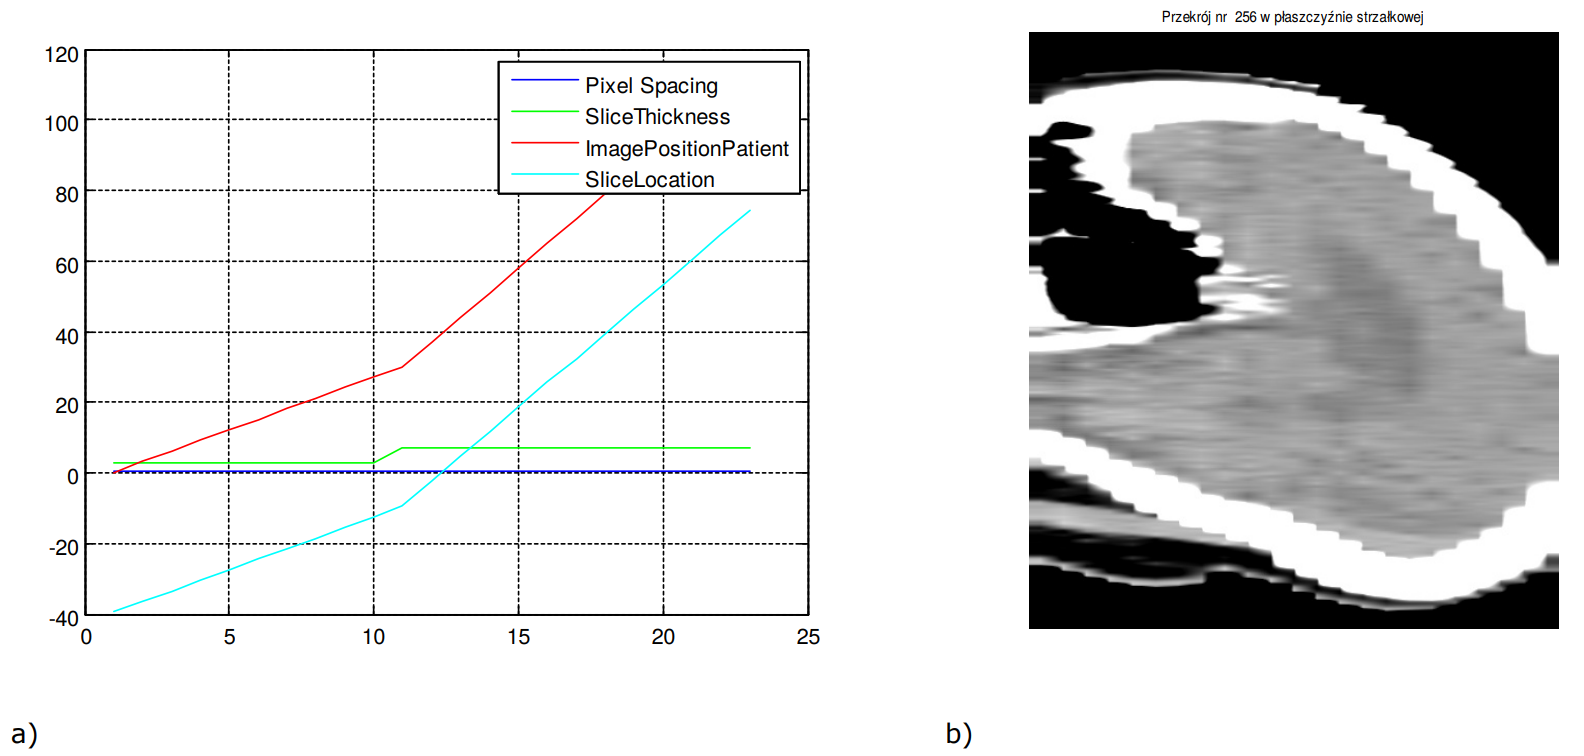


<center>Rys. 5.1 Przykładowy, prawidłowo wczytany wolumin danych CT. a) wektory  metadanych, b) przekrój woluminu CT (ok. 256 przekroju) w płaszczyźnie pionowej. Przekrój został przeskalowany do rozmiarów 512 x 512 funkcją `imresize(...)`.</center>

5.   W oparciu o funkcję `imcontrast(...)` wyznacz dwa progi jasności obrazu tak, aby możliwie dobrze widoczne była struktury miękkie mózgu (rys. 5.2). 
6.   Wyświetlaj w pętli na kolejnych figurach następujące po sobie przekroje (w płaszczyźnie poziomej (rys. 5.2), uwzględniając progi jasności wyznaczone w pkt.5).
7.   Spróbuj zrealizować testowe wizualizacje 3D posiadanych danych, podobnie jak to zostało zrobione w odnośniku drugim, podanym na początku zadania 3.

>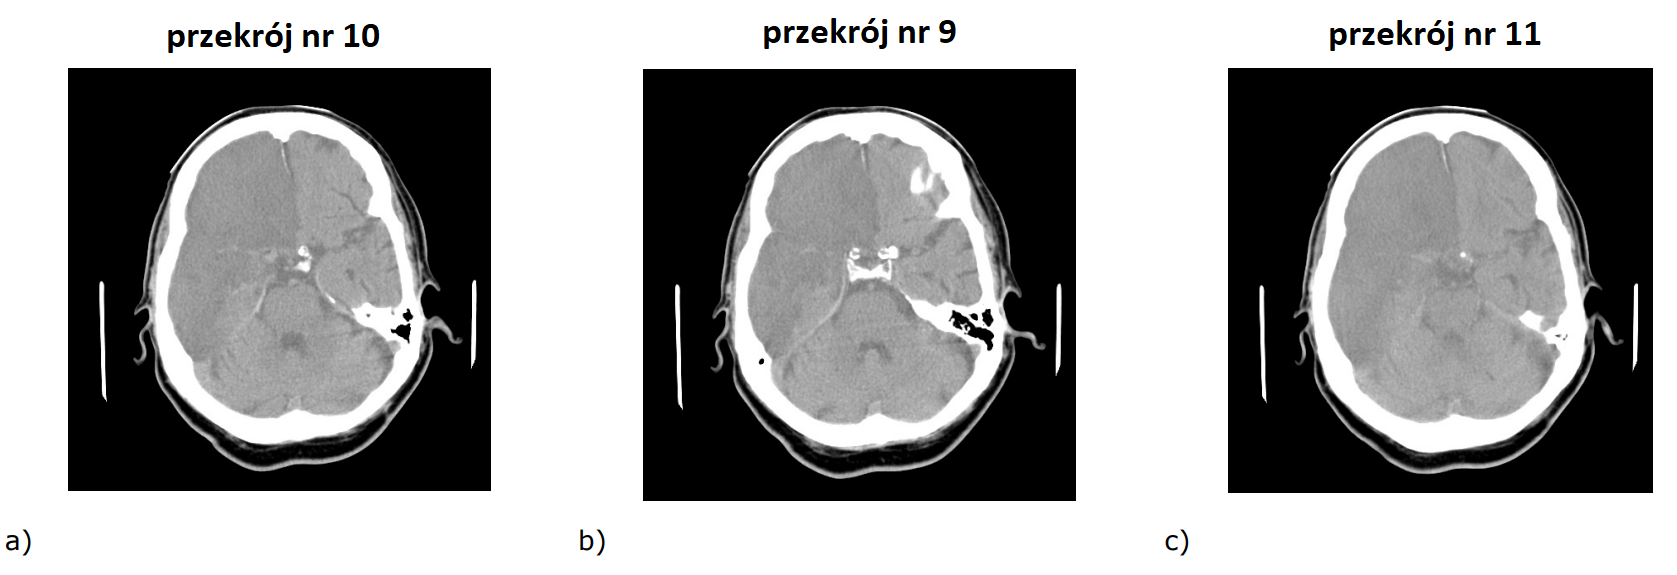
<center>Rys. 5.2. Kolejne przekroje zapisanego woluminu CT.</center>

In [ ]:
!pip install pydicom
import gdown

gdown.download('https://drive.google.com/uc?id=1TNv99YjaWP31f9WUw-dh41GqCa2wi92i', 'CT_volumes.rar', quiet=True)
!unrar x CT_volumes.rar




---


<strong>4.b (+0.5 pkt).</strong> Spróbuj napisać prosty algorytm, który będzie wykrywał wystąpienie udaru oraz możliwie dobrze segmentował (ekstrahował) go z obrazu. Obszar hipodensyjny (dotknięty udarem) mózgowia jest widoczny na poszczególnych przekrojach jako ciemniejsze obszary (np. rys. 5.2 a-c). Na załączonych testowych woluminach `CT_1` i `CT_2` może on występować na kilku lub kilkunastu przekrojach, w obszarze górnej części czaszki. Przy tworzeniu algorytmu możesz (ALE NIE MUSISZ!) wykorzystać wymienione poniżej techniki przetwarzania obrazu.

1.   Zastosowanie filtrów, przykładowo: Gaussa (funkcja `fspecial(...)`), medianowego (funkcja `medfilt2(...)`), lub innych metod przetwarzania obrazów (ZAPROPONUJ, ZAIMPLEMENTUJ), w celu usunięcia zakłóceń i poprawienia widoczności obszarów hipodensyjnych z udarem (rys. 5.3a). Spróbuj za pomocą odpowiedniej  kolejności, liczby i rodzaju stosowanych filtracji jak najlepiej (pod kątem widoczności lub działania proponowanego algorytmu) uwypuklić obszary dotknięte udarem.
2.   Sprawdzenie symetryczności przekroju (lub jej braku – przypadek udaru!) względem szczeliny podłużnej mózgu. W tym celu na początku jest konieczne wyznaczenie (automatyczne) osi symetrii danego przekroju. Można to zrobić np. za pomocą opisania elipsy na masce kości czaszki (rys. 5.3b) (funkcja `regionprops(...)`, parametr np. ‘MajorAxisLength'). Jako miarę symetrii możesz przyjąć np. sumę kwadratów różnic pikseli po obu stronach płaszczyzny symetrii, ilość informacji wzajemnej, dywergencję Kullbacka-Leiblera lub inną zaproponowaną. Uwaga: poszczególne przekroje nie są idealnie symetryczne ze względu na anatomię oraz odchylenie głowy pacjenta we wszystkich płaszczyznach podczas skanowania, dlatego oś uzyskana tą metodą niekoniecznie będzie się pokrywać z anatomiczną osią symetrii.
3.   Wyodrębnienie krawędzi obszarów o tej samej jasności, np. filtrami Sobela, Canny’ego (funkcja `edge(...)`) lub obliczając gradient 2D/3D (funkcja `[CTx,CTy,CTz]=gradient(CT)`, a następnie obliczenie pierwiastka z sumy kwadratów odpowiadających sobie elementów macierzy `Ctx`, `Cty`, `CTz`, rys. 5.3c).
4.   Konturowanie obszarów o tej samej jasności, np. za pomocą funkcji takich jak `contour(...)`, `imcontour(...)`, `contourc(...)`, `contourslice(...)`.
5.   Porównanie ze wzorcem (dane `CT_clear`, czyli CT bez udaru), wolnym od zmian hipodensyjnych (CT zdrowego mózgu).

Przetestuj działanie algorytmu na woluminach danych z udarem (`CT_1` i `CT_2`) oraz bez zmian hipodensyjnych (`CT_clear`).

>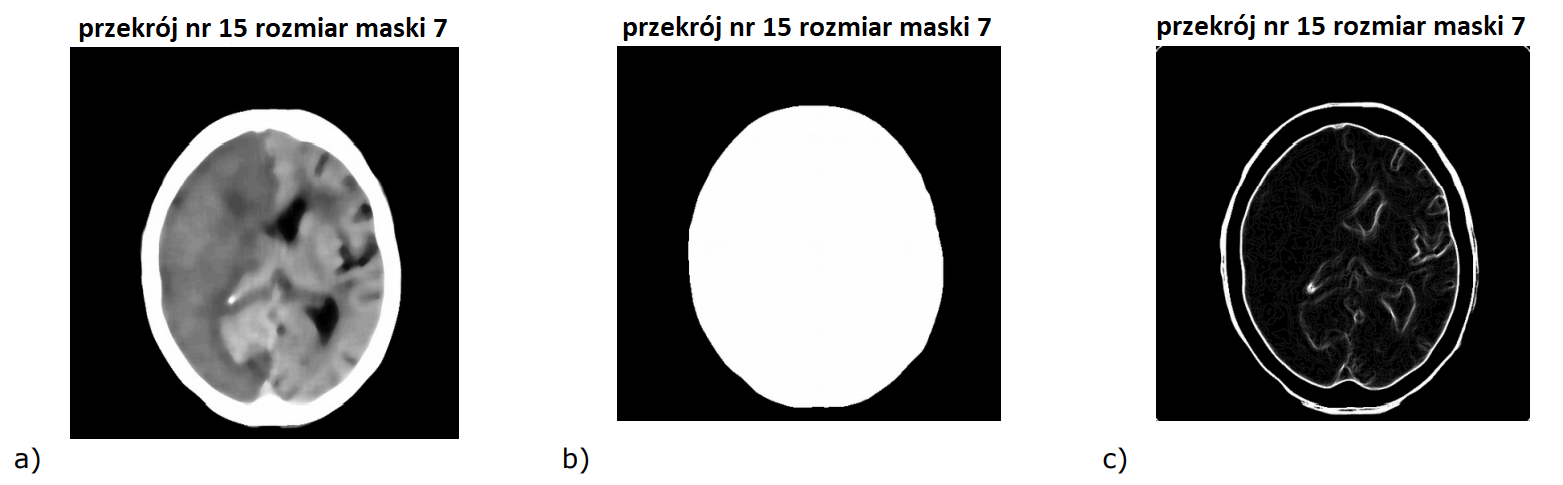
<center><strong>Rys. 5.3.</strong> Przykładowe przetwarzanie tego samego przekroju: a) poprawienie widoczności udaru, b) binaryzacja (górny próg jasności odpowiada kościom czaszki) + wypełnienie (funkcja `imfill(...)`), c) pierwiastek z kwadratu gradientów 2D (funkcja `gradient()`)</center>

In [ ]:
!pip install pydicom
import gdown

gdown.download('https://drive.google.com/uc?id=1TNv99YjaWP31f9WUw-dh41GqCa2wi92i', 'CT_volumes.rar', quiet=True)
!unrar x CT_volumes.rar
